# Подготовка

In [ ]:
!pip install geopandas
import psycopg2
import itertools
import numpy as np
import pandas as pd
import pandas_profiling as pd_prof
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import lognorm
from collections import Counter
import geopandas as gpd

%matplotlib inline
plt.rcParams['figure.figsize'] = [15, 8]
sns.set_style("whitegrid")

     |████████████████████████████████| 931kB 4.7MB/s 
     |████████████████████████████████| 14.7MB 57.1MB/s 
     |████████████████████████████████| 10.4MB 42.6MB/s 


/usr/local/lib/python3.6/dist-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


Функция, выгружающая таблицы из базы и формирующая датафреймы

In [ ]:
def call_base():
    try:
        connection = psycopg2.connect(user = "analytics",
                                    password = "HRanalytics",
                                    host = 'rc1c-fhrb9f1e0l9g611h.mdb.yandexcloud.net',
                                    port = "6432",
                                    database = 'hr-analytics')

        cursor = connection.cursor()
        cursor.execute("SELECT column_name FROM information_schema.columns WHERE table_name =  'orders';")
        orders_columns_list = [element[0] for element in cursor.fetchall()]
        cursor.execute("SELECT * from orders;")
        orders_data = cursor.fetchall()
        cursor.execute("SELECT column_name FROM information_schema.columns WHERE table_name =  'delivery_windows';")
        delivery_windows_columns_list = [element[0] for element in cursor.fetchall()]
        cursor.execute("SELECT * from delivery_windows;")
        delivery_windows_data = cursor.fetchall()
        cursor.execute("SELECT column_name FROM information_schema.columns WHERE table_name =  'stores';")
        stores_columns_list = [element[0] for element in cursor.fetchall()]
        cursor.execute("SELECT * from stores;")
        stores_data = cursor.fetchall()
        cursor.execute("SELECT column_name FROM information_schema.columns WHERE table_name =  'addresses';")
        addresses_columns_list = [element[0] for element in cursor.fetchall()]
        cursor.execute("SELECT * from addresses;")
        addresses_data = cursor.fetchall()
    except (Exception, psycopg2.Error) as error :
        print ("Error while connecting to PostgreSQL", error)
    finally:
            if(connection):
                cursor.close()
                connection.close()
                print("PostgreSQL connection is closed")
            orders_df = pd.DataFrame.from_records(orders_data, columns=orders_columns_list)
            delivery_windows_df = pd.DataFrame.from_records(delivery_windows_data, columns=delivery_windows_columns_list) 
            stores_df = pd.DataFrame.from_records(stores_data, columns=stores_columns_list) 
            addresses_df = pd.DataFrame.from_records(addresses_data, columns=addresses_columns_list)  
            return orders_df, delivery_windows_df, stores_df, addresses_df

Выгружаем таблицы

In [ ]:
%%time
orders_df, delivery_windows_df, stores_df, addresses_df = call_base()

PostgreSQL connection is closed
CPU times: user 3.59 s, sys: 755 ms, total: 4.34 s
Wall time: 16.3 s


In [ ]:
orders_df.describe()

,id,user_id,total_cost,cost,item_total,promo_total,total_weight,total_quantity,ship_address_id,store_id,delivery_window_id,is_damaged
count,3.342450e+05,334245.000000,334245.000000,334245.000000,334245.000000,334245.000000,3.342450e+05,334245.000000,3.342450e+05,334245.000000,334244.000000,334245.000000
mean,4.188269e+06,177843.373415,189.069228,257.827092,4917.515152,-66.523240,2.692579e+04,44.192721,1.388983e+06,23.189529,370981.101713,0.716510
std,6.588292e+05,130990.121425,175.353450,172.493721,5526.465519,304.918133,4.187307e+04,75.054887,6.108061e+05,29.692184,165423.948184,0.450693
min,5.570000e+02,31.000000,-298.000000,0.000000,0.000000,-39899.300000,0.000000e+00,0.000000,6.017000e+03,1.000000,75244.000000,0.000000
25%,3.634639e+06,84872.000000,0.000000,199.000000,2566.000000,0.000000,9.685000e+03,18.000000,8.531730e+05,8.000000,231656.000000,0.000000
50%,4.134595e+06,146590.000000,199.000000,299.000000,3873.000000,0.000000,1.818000e+04,31.000000,1.333773e+06,11.000000,372995.000000,1.000000
75%,4.745424e+06,243751.000000,299.000000,299.000000,5806.000000,0.000000,3.193500e+04,50.000000,1.890743e+06,21.000000,517636.000000,1.000000
max,5.513202e+06,682383.000000,9500.000000,9500.000000,480746.000000,0.000000,3.864000e+06,7728.000000,2.669705e+06,120.000000,638550.000000,1.000000


In [ ]:
print(f"период заказов с {str(orders_df['created_at'].min())} по {str(orders_df['created_at'].max())}")
print(orders_df['user_id'].nunique())

период заказов с 2018-01-05 00:07:04 по 2019-08-04 17:39:12
119031


У нас есть база заказов во временном промежутке 1.5 года (с января 2018 по август 2019) на 334245 строк (это без учета дублей) и 119031 уникальный пользователь

Для первичной оценки воспользумся библиотекой pandasProfiling - полезная штука, когда нужно быстро оценить, что вообще у тебя происходит в таблице. Перенес ее под кат, здесь она чисто в ознакомительных целях.

# Профиль orders_df

In [ ]:
pd_prof.ProfileReport(orders_df)

/usr/local/lib/python3.6/dist-packages/pandas_profiling/describe.py:392: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  variable_stats = pd.concat(ldesc, join_axes=pd.Index([names]), axis=1)


Number of variables,15
Number of observations,334245
Total Missing (%),0.0%
Total size in memory,38.3 MiB
Average record size in memory,120.0 B
Numeric,9
Categorical,1
Boolean,1
Date,2
Text (Unique),0
Rejected,2


# Анализ

In [ ]:
analyse_orders_df = orders_df.copy()

Для начала немного модифицируем таблицу - 

In [ ]:
# функция-обработчик скидок
def treat_discount(value):
    if value > 100.0:
        return 100.0
    else:
        return value

In [ ]:
# добавим инфу из таблицы с магазинами
stores_df = stores_df.rename(columns={"id": "store_id"})
analyse_orders_df = pd.merge(analyse_orders_df, stores_df, how='left', on=['store_id'])
# аналогично добавим в таблицу адреса доставок
analyse_orders_df = pd.merge(analyse_orders_df, addresses_df, how='left', left_on=['ship_address_id'], right_on=['id'])
# вычислим полную стоимость заказа - с доставкой, скидками, и пр.
analyse_orders_df['total'] = analyse_orders_df['total_cost'] + analyse_orders_df['item_total'] + analyse_orders_df['promo_total']
# вычислим, какой процент от полной стоимости заказа составляет скидка
analyse_orders_df['discount'] = (1 - analyse_orders_df['total']/(analyse_orders_df['cost'] + analyse_orders_df['item_total']))*100
analyse_orders_df['discount'] = analyse_orders_df['discount'].fillna(0.0)
analyse_orders_df['discount'] = analyse_orders_df.apply(lambda row: treat_discount(row['discount']), axis=1)
# посмотрим, сколько времени прошло между заказом и доставкой
analyse_orders_df['delay'] = analyse_orders_df.shipped_at - analyse_orders_df.created_at
# также выделим отдельно часы из дат заказа и доставки
analyse_orders_df['created_hour'] = pd.DatetimeIndex(analyse_orders_df.created_at).hour
analyse_orders_df['shipped_hour'] = pd.DatetimeIndex(analyse_orders_df.shipped_at).hour
analyse_orders_df['day'] = pd.DatetimeIndex(analyse_orders_df.shipped_at).dayofyear

In [ ]:
analyse_orders_df.describe()

,id_x,user_id,total_cost,cost,item_total,promo_total,total_weight,total_quantity,ship_address_id,store_id,delivery_window_id,is_damaged,city,retailer_id,lat,lon,id_y,total,discount,delay,created_hour,shipped_hour,day
count,3.342450e+05,334245.000000,334245.000000,334245.000000,334245.000000,334245.000000,3.342450e+05,334245.000000,3.342450e+05,334245.000000,334244.000000,334245.000000,332629.000000,332629.00000,334231.000000,334231.000000,3.342310e+05,334245.000000,334245.000000,334245,334245.000000,334245.000000,334245.000000
mean,4.188269e+06,177843.373415,189.069228,257.827092,4917.515152,-66.523240,2.692579e+04,44.192721,1.388983e+06,23.189529,370981.101713,0.716510,1.882740,1.35766,55.671294,39.357004,1.389013e+06,5040.061141,3.891672,4 days 04:05:40.340139,12.156777,12.526835,167.457111
std,6.588292e+05,130990.121425,175.353450,172.493721,5526.465519,304.918133,4.187307e+04,75.054887,6.108061e+05,29.692184,165423.948184,0.450693,3.084996,2.16251,0.538266,5.383116,6.107995e+05,5545.954526,8.897651,16 days 17:10:45.698381,4.842716,4.406996,93.152693
min,5.570000e+02,31.000000,-298.000000,0.000000,0.000000,-39899.300000,0.000000e+00,0.000000,6.017000e+03,1.000000,75244.000000,0.000000,1.000000,1.00000,0.000000,0.000000,6.017000e+03,-2864.000000,0.000000,-3 days +00:02:25,0.000000,0.000000,1.000000
25%,3.634639e+06,84872.000000,0.000000,199.000000,2566.000000,0.000000,9.685000e+03,18.000000,8.531730e+05,8.000000,231656.000000,0.000000,1.000000,1.00000,55.681259,37.535757,8.531950e+05,2679.000000,0.000000,0 days 09:53:14,8.000000,9.000000,98.000000
50%,4.134595e+06,146590.000000,199.000000,299.000000,3873.000000,0.000000,1.818000e+04,31.000000,1.333773e+06,11.000000,372995.000000,1.000000,1.000000,1.00000,55.754805,37.611792,1.333822e+06,4006.000000,0.000000,0 days 21:42:24,12.000000,12.000000,165.000000
75%,4.745424e+06,243751.000000,299.000000,299.000000,5806.000000,0.000000,3.193500e+04,50.000000,1.890743e+06,21.000000,517636.000000,1.000000,1.000000,1.00000,55.807478,37.728430,1.890772e+06,5940.000000,4.555809,1 days 21:44:32,16.000000,16.000000,216.000000
max,5.513202e+06,682383.000000,9500.000000,9500.000000,480746.000000,0.000000,3.864000e+06,7728.000000,2.669705e+06,120.000000,638550.000000,1.000000,23.000000,16.00000,56.381402,73.498209,2.669705e+06,481045.000000,100.000000,515 days 01:31:12,23.000000,23.000000,365.000000


In [ ]:
# есть 14 заказов,у которых по сути нет адреса доставки. уберем их, чтобы не смущали
analyse_orders_df[(analyse_orders_df['lat'].isna())].head()

,id_x,user_id,total_cost,cost,item_total,promo_total,total_weight,total_quantity,state,shipped_at,created_at,ship_address_id,store_id,delivery_window_id,is_damaged,city,retailer_id,lat,lon,id_y,elevator,floor,total,discount,delay,created_hour,shipped_hour,day
896,3189843,81119,0.0,0.0,7171,0.0,26236,57,shipped,2018-01-09 07:43:45,2018-01-08 09:32:47,454019,12,77513.0,1,1.0,1.0,NaN,NaN,NaN,NaN,NaN,7171.0,0.00000,0 days 22:10:58,9,7,9
5272,3228558,11001,190.0,190.0,9126,0.0,3000,6,shipped,2018-02-06 09:08:38,2018-01-22 05:46:35,480630,1,84611.0,0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,9316.0,0.00000,15 days 03:22:03,5,9,37
11703,2927902,20640,290.0,290.0,1870,0.0,9350,30,shipped,2018-02-14 08:51:03,2018-02-14 05:57:23,516864,1,97941.0,0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,2160.0,0.00000,0 days 02:53:40,5,8,45
39203,3470714,112901,0.0,0.0,4262,0.0,15264,36,shipped,2018-09-16 13:26:43,2018-05-11 17:25:54,690483,21,244248.0,1,1.0,1.0,NaN,NaN,NaN,NaN,NaN,4262.0,0.00000,127 days 20:00:49,17,13,259
53977,3423210,58294,299.0,299.0,2811,-500.0,26215,29,shipped,2018-06-20 18:37:47,2018-06-12 20:57:13,369583,14,176118.0,1,1.0,1.0,NaN,NaN,NaN,NaN,NaN,2610.0,16.07717,7 days 21:40:34,20,18,171


In [ ]:
analyse_orders_df = analyse_orders_df.dropna(subset=['lat', 'lon'])

## Города

Первым делом хочется вычислить, какой id какому городу соответствует.

In [ ]:
stores_df['city'].nunique() # 9 уникальных id - на сайте есть 17 городов.

9

In [ ]:
# ожидаемо, у нас есть 1616 строк, для которых в таблице с магазинами нет id
analyse_orders_df[(analyse_orders_df['city'].isna())]

,id_x,user_id,total_cost,cost,item_total,promo_total,total_weight,total_quantity,state,shipped_at,created_at,ship_address_id,store_id,delivery_window_id,is_damaged,city,retailer_id,lat,lon,id_y,elevator,floor,total,discount,delay,created_hour,shipped_hour,day
25,3190418,67883,190.0,190.0,6875,0.0,31139,68,shipped,2018-01-05 13:52:19,2018-01-05 05:42:17,448983,6,75484.0,1,NaN,NaN,55.720003,37.426943,448983.0,None,5,7065.0,0.0,0 days 08:10:02,5,13,5
31,3166322,41015,290.0,290.0,4641,0.0,22425,37,shipped,2018-01-05 10:51:12,2018-01-05 06:06:10,448362,6,75481.0,1,NaN,NaN,55.771078,37.410786,448362.0,passenger,17,4931.0,0.0,0 days 04:45:02,6,10,5
73,3190939,80198,0.0,0.0,1807,0.0,15200,18,shipped,2018-01-05 11:24:42,2018-01-05 07:54:46,448658,6,75483.0,1,NaN,NaN,55.744783,37.415579,448658.0,None,7,1807.0,0.0,0 days 03:29:56,7,11,5
79,3174050,14860,90.0,90.0,11994,0.0,42732,108,shipped,2018-01-08 07:46:13,2018-01-05 08:11:42,448783,6,77116.0,1,NaN,NaN,55.678434,37.268016,448783.0,None,4,12084.0,0.0,2 days 23:34:31,8,7,8
125,3190440,80211,290.0,290.0,3061,0.0,5932,28,shipped,2018-01-05 15:34:35,2018-01-05 10:13:30,449372,6,75485.0,1,NaN,NaN,55.735472,37.453622,449372.0,None,3,3351.0,0.0,0 days 05:21:05,10,15,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52978,3523860,119801,199.0,199.0,5938,0.0,15613,34,shipped,2018-06-10 17:47:14,2018-06-10 12:26:38,761486,56,169849.0,1,NaN,NaN,55.817194,37.717689,761486.0,None,5,6137.0,0.0,0 days 05:20:36,12,17,161
53009,3473291,113206,199.0,199.0,6726,0.0,8783,25,shipped,2018-06-10 18:24:30,2018-06-10 13:30:32,761528,58,169862.0,1,NaN,NaN,55.548313,37.551501,761528.0,None,17,6925.0,0.0,0 days 04:53:58,13,18,161
53210,3541040,111925,299.0,299.0,854,0.0,3150,7,shipped,2018-06-12 07:54:54,2018-06-11 06:39:43,762304,6,170912.0,0,NaN,NaN,55.723725,37.425040,762304.0,None,7,1153.0,0.0,1 days 01:15:11,6,7,163
53262,3433904,103225,299.0,299.0,5858,0.0,47542,56,shipped,2018-06-12 12:46:24,2018-06-11 08:53:30,762512,6,170914.0,1,NaN,NaN,55.693566,37.341990,762512.0,None,,6157.0,0.0,1 days 03:52:54,8,12,163


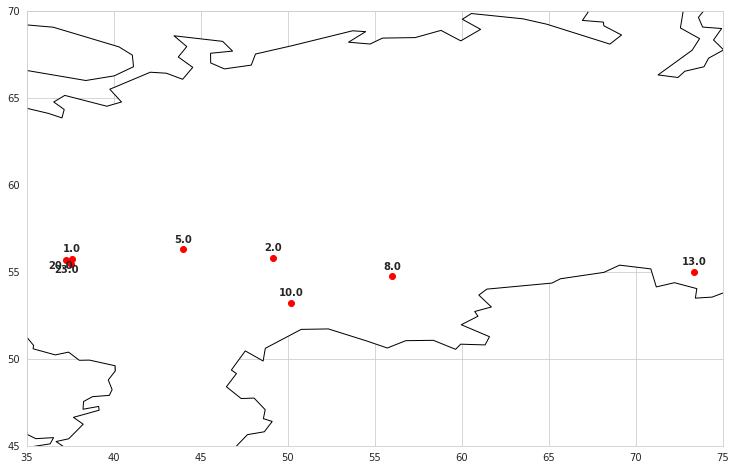

In [ ]:
# Отобразим города на карте. Для этого сгруппируем заказы по id городов и возьмем средние координаты
mean_coords = analyse_orders_df.groupby('city').mean()[['lat', 'lon']]

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
gdf = gpd.GeoDataFrame(mean_coords, geometry=gpd.points_from_xy(mean_coords.lon, mean_coords.lat))

ax = world[world.continent == 'Europe'][:1].plot(
    color='white', edgecolor='black')
gdf.plot(ax=ax, color='red')
plt.rcParams['figure.figsize'] = [20, 20]
for idx, row in gdf.iterrows():
    if idx >= 20:
        plt.annotate(s=idx, xy=(row.lon-0.3,row.lat-0.5), horizontalalignment='center', weight='semibold')
    else:
        plt.annotate(s=idx, xy=(row.lon,row.lat+0.4), horizontalalignment='center', weight='semibold')
plt.xlim([35, 75])
plt.ylim([45, 70])
plt.show()

Полученная картина позволяет однозначно определить города, используемые в таблице.

In [ ]:
# Занятно, города МО идут с id => 20
city_dict = {1: "Москва",2: "Казань",5: "Нижний Новгород",8: "Уфа",
             10: "Самара",13: "Омск",20: "Одинцово",23: "Подольск"}
analyse_orders_df['city_name'] = analyse_orders_df['city'].map(city_dict)

In [ ]:
analyse_orders_df.head()

,id_x,user_id,total_cost,cost,item_total,promo_total,total_weight,total_quantity,state,shipped_at,created_at,ship_address_id,store_id,delivery_window_id,is_damaged,city,retailer_id,lat,lon,id_y,elevator,floor,total,discount,delay,created_hour,shipped_hour,day,city_name
0,3158715,61138,290.0,290.0,2543,0.0,89906,35,shipped,2018-01-05 10:50:00,2018-01-05 00:07:04,448086,2,75258.0,0,1.0,1.0,55.603020,37.717696,448086.0,passenger,6,2833.0,0.0,0 days 10:42:56,0,10,5,Москва
1,3182881,73307,190.0,190.0,6076,0.0,30275,52,shipped,2018-01-06 15:33:54,2018-01-05 02:04:42,450946,10,75860.0,1,1.0,1.0,55.835607,37.519755,450946.0,None,3,6266.0,0.0,1 days 13:29:12,2,15,6,Москва
2,3146329,75386,290.0,290.0,2617,0.0,93040,24,shipped,2018-01-11 06:40:38,2018-01-05 02:07:35,458911,14,78635.0,1,1.0,1.0,55.713900,37.516982,458911.0,passenger,6,2907.0,0.0,6 days 04:33:03,2,6,11,Москва
3,3150465,45970,290.0,290.0,3422,0.0,10518,23,shipped,2018-01-06 12:55:22,2018-01-05 02:15:15,448101,21,75403.0,1,1.0,1.0,55.788035,37.558217,448101.0,None,9,3712.0,0.0,1 days 10:40:07,2,12,6,Москва
4,3169087,49089,90.0,90.0,3666,0.0,22740,31,shipped,2018-01-06 16:17:27,2018-01-05 02:48:52,451302,3,75825.0,1,1.0,1.0,55.702004,37.761344,451302.0,None,14,3756.0,0.0,1 days 13:28:35,2,16,6,Москва


посмотрим разделение юзеров по городам. Оно достаточно логично выглядит.

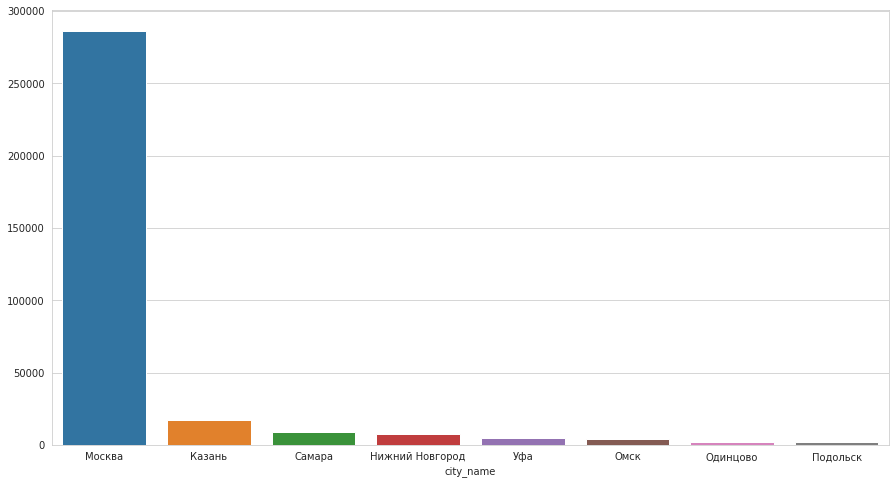

In [ ]:
plt.rcParams['figure.figsize'] = [15, 8]
users_by_city = analyse_orders_df.groupby('city_name').count()['user_id'].sort_values(ascending=False)
sns.barplot(x=users_by_city.index, y=users_by_city.values)

## Пользователи

Теперь посмотрим подробнее пользователей. Для начала оценим количество заказов одним пользователем

(0, 50)

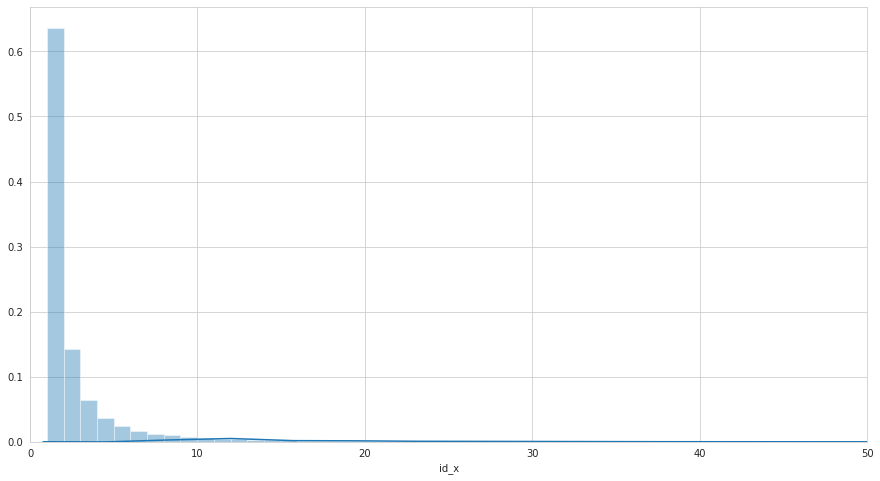

In [ ]:
plt.rcParams['figure.figsize'] = [15, 8]
users_count = analyse_orders_df.groupby('user_id').count()['id_x']
sns.distplot(users_count, bins=475)
plt.xlim([0, 50])

In [ ]:
one_order_part = users_count.value_counts().iloc[(users_count.value_counts().index == 1)]/len(analyse_orders_df)
print (f"Видно, что подавляющее большинство ограничивается одним заказом. Доля таких юзеров {round(one_order_part.values[0],2)}")

Видно, что подавляющее большинство ограничивается одним заказом. Доля таких юзеров 0.23


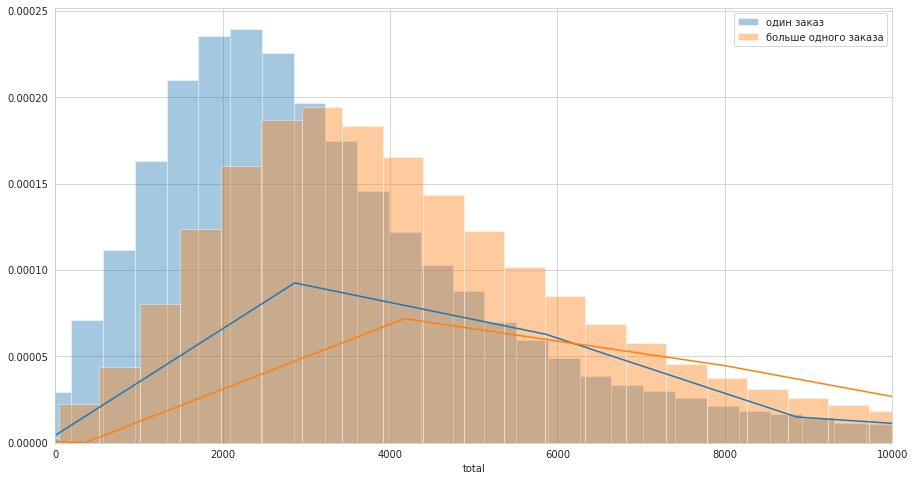

In [ ]:
sns.distplot(analyse_orders_df[(analyse_orders_df['user_id'].isin(users_count.iloc[(users_count.values == 1)].index))]['total'], bins=1000, label='один заказ')
sns.distplot(analyse_orders_df['total'], bins=1000, label='больше одного заказа')
plt.xlim([0, 10000])
plt.legend()

In [ ]:
one_order_df = analyse_orders_df[(analyse_orders_df['user_id'].isin(users_count.iloc[(users_count.values == 1)].index))]
print(f"Медианный чек людей, сделавших один заказ: {one_order_df['total'].median()}")
mean_quantity = round(one_order_df[(one_order_df['total'] > 2800) & 
                                       (one_order_df['total'] < 2900)]['total_quantity'].mean(),0)
print(f"Среднее количество товаров при таком чеке: {mean_quantity}")
print(f"Медианный чек остальных: {analyse_orders_df['total'].median()}")
mean_quantity = round(analyse_orders_df[(analyse_orders_df['total'] > 3800) & 
                                       (analyse_orders_df['total'] < 3900)]['total_quantity'].mean(),0)
print(f"Среднее количество товаров при таком чеке: {mean_quantity}")

Медианный чек людей, сделавших один заказ: 2897.0
Среднее количество товаров при таком чеке: 23.0
Медианный чек остальных: 4006.0
Среднее количество товаров при таком чеке: 33.0


Достаточно логично. Сумма чека и количество товаров выглядит плюс-минус как оптовая семейная закупка на неделю, даже для тех, кто сделал всего один заказ

так как Москвы сильно больше, чем осталных городов, глянем отдельно только их распределение по чекам. Подмосковье очень близко по среднему чеку к Москве, в то время как остальные города пракически равны между собой.

{'Казань': 3310.5, 'Самара': 3248.0, 'Нижний Новгород': 3136.0, 'Уфа': 3157.0, 'Омск': 3091.0, 'Одинцово': 4219.0, 'Подольск': 3762.275}


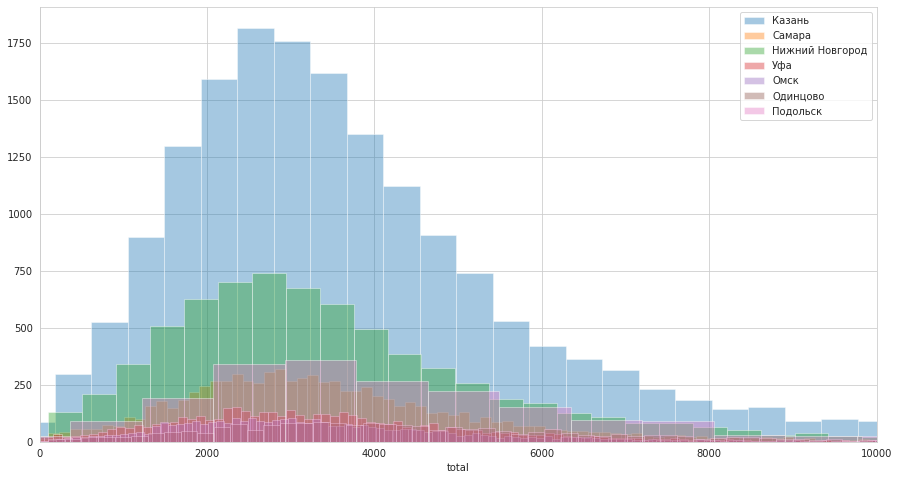

In [ ]:
median_check_dict = {}
for city in users_by_city.index[1:]:
    sns.distplot(analyse_orders_df[(analyse_orders_df['city_name'] == city)]['total'], bins=500, label=city, kde=False)
    median_check_dict[city] = analyse_orders_df[(analyse_orders_df['city_name'] == city)]['total'].median()
plt.xlim([0, 10000])
plt.legend()
print(median_check_dict)

## попробуем посмотреть, как меняются суммы чеков у людей, заказывающих больше раза

In [ ]:
check_sum_test = analyse_orders_df.copy()
check_sum_test = check_sum_test.sort_values(by=['user_id','created_at'])

In [ ]:
# В этой ячейка хитрые манипуляции по созданию отдельной колонки с порядковым номером заказа для каждого пользователя
users_counter = Counter(check_sum_test['user_id'].values)
users_counter_list_one = [[key for x in range(0, users_counter[key])] for key in users_counter.keys()]
first_index_list = list(itertools.chain.from_iterable(users_counter_list_one))
users_counter_list_two = [[x for x in range(1, users_counter[key]+1)] for key in users_counter.keys()]
second_index_list = list(itertools.chain.from_iterable(users_counter_list_two))
tuples = list(zip(*[first_index_list, second_index_list]))
index = pd.MultiIndex.from_tuples(tuples, names=['user_id', 'occurence_num'])
# df = pd.DataFrame(check_test, index=index)
check_sum_test['occurence_num'] = second_index_list

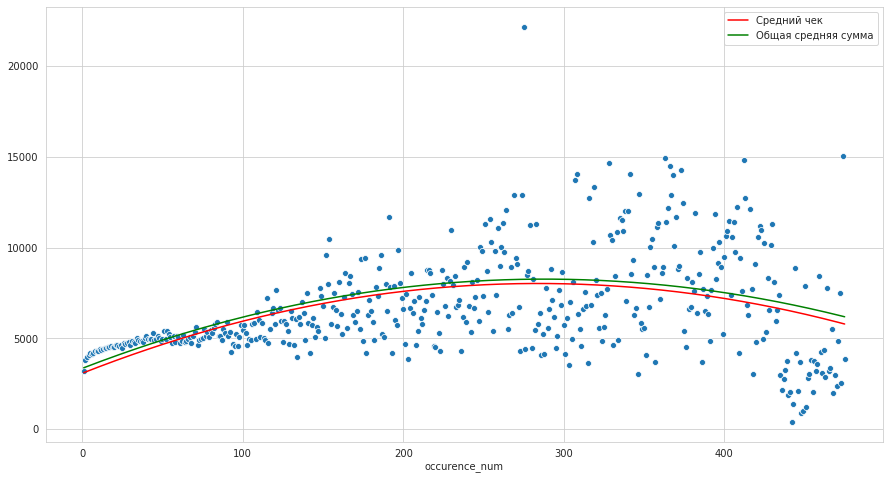

In [ ]:
mean_check_by_occurrence = check_sum_test.groupby('occurence_num').median()['item_total']
mean_total_by_occurrence = check_sum_test.groupby('occurence_num').median()['total']
sns.scatterplot(x=mean_check_by_occurrence.index, y=mean_check_by_occurrence.values)

trend = np.polyfit(mean_check_by_occurrence.index, mean_check_by_occurrence.values, deg=2)
trendgraph = np.poly1d(trend) 
plt.plot(mean_check_by_occurrence.index,trendgraph(mean_check_by_occurrence.index), 'red', label='Средний чек')

trend_total = np.polyfit(mean_total_by_occurrence.index, mean_total_by_occurrence.values, deg=2)
trendgraph_total = np.poly1d(trend_total) 
plt.plot(mean_total_by_occurrence.index,trendgraph_total(mean_total_by_occurrence.index), 'green', label='Общая средняя сумма')
plt.legend()

Линия тренда говорит нам о том, что с ростом количества заказов, средняя сумма чека падает, при этом затраты на доставку никак не меняются (линии чека и общей суммы эквидистантны). При этом с ростом количества заказов также увеличивается разброс, что затрудняет вывод только лишь по линии тренда

## Зависимость выручки от количества заказов

In [ ]:
user_count_series = analyse_orders_df.groupby('user_id').count()['id_x']
total_count_series = analyse_orders_df.groupby('user_id')['total'].sum()

In [ ]:
total_user = pd.concat([user_count_series, total_count_series], axis=1)

In [ ]:
total_by_number = total_user.groupby('id_x')['total'].median()

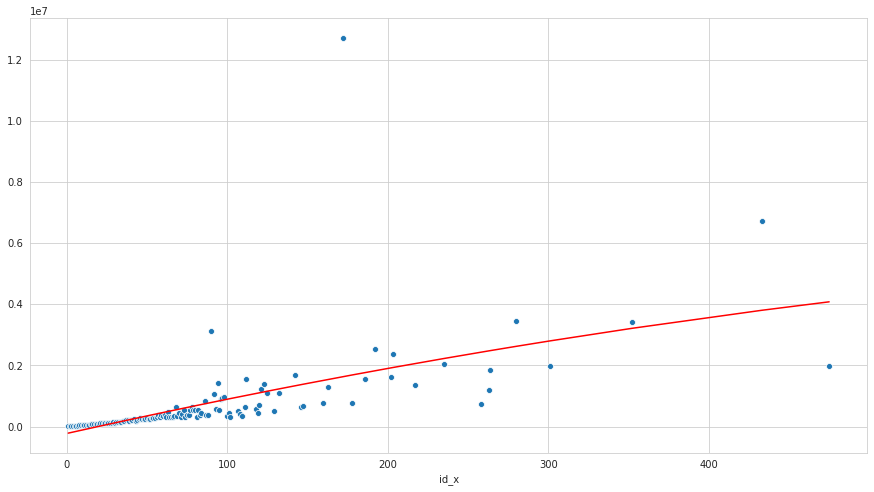

In [ ]:
sns.scatterplot(x=total_by_number.index, y=total_by_number.values)
total_trend = np.polyfit(total_by_number.index, total_by_number.values, deg=2)
trendgraph = np.poly1d(total_trend) 
plt.plot(total_by_number.index,trendgraph(total_by_number.index), 'red')

Ничего неожиданного. Если верить такой грубой линии тренда, каждые 200 заказов с одного пользователя в среднем приносят 200к выручки. Рискну предположить, что выбросы выше линии - это очень хорошие заказчики-юрлица.

## Анализ скидок

Text(0.5, 1.0, 'Общее распределение скидок, %')

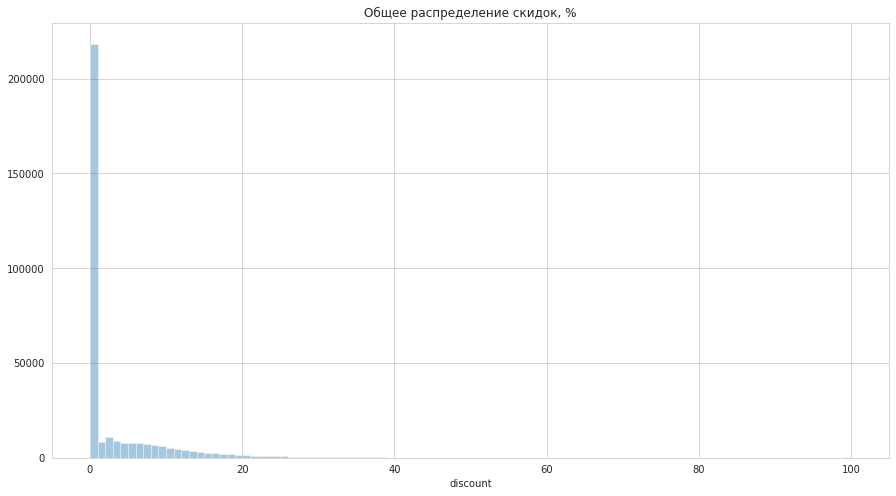

In [ ]:
sns.distplot(analyse_orders_df.discount, bins=100, kde=False)
plt.title('Общее распределение скидок, %')

Хочется посмотреть, будут ли люди, получившие скидку на первый заказ, продолжать пользоваться сервисом. Скидки на чек и на доставку я не разделяю, сужу по себе - мне для принятия решения о заказе достаточно какого-то одного типа скидки, без разницы, на доставку это или на сам заказ.

Сначала посмотрим на распределение скидок для первого заказа

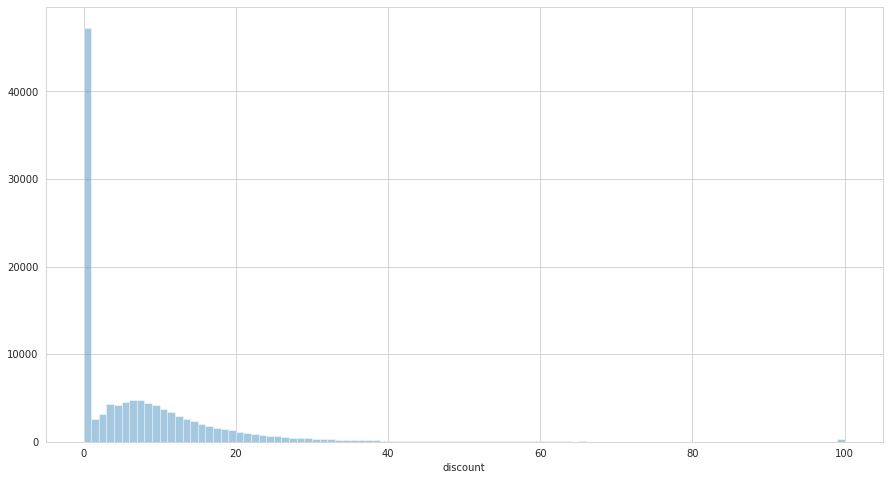

In [ ]:
first_order_df = check_sum_test[(check_sum_test['occurence_num'] == 1)]
sns.distplot(first_order_df.discount, bins=100, kde=False)

In [ ]:
# Возьмем скидку из первого заказа каждого пользователя
first_order_users = first_order_df.groupby('user_id')['discount'].sum()
# И добавим количество заказов кадого пользователя
user_by_first_discount = pd.concat([user_count_series, first_order_users], axis=1)
user_by_first_discount

,id_x,discount
user_id,,
31,50,0.000000
45,40,0.000000
60,1,0.000000
63,1,9.150805
97,8,3.842459
...,...,...
681550,1,4.355018
681627,1,9.153679
681806,1,6.830553


Text(0.5, 1.0, 'зависимость количества заказов от скидки на первый заказ')

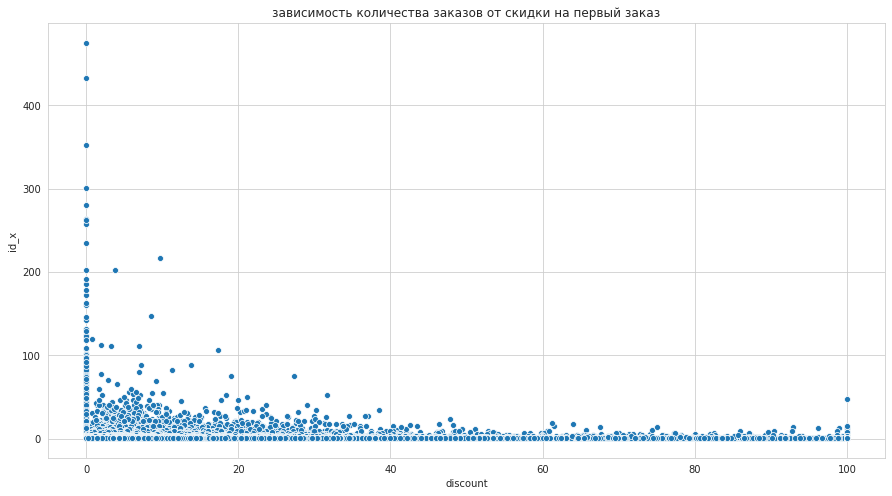

In [ ]:
sns.scatterplot(x='discount', y='id_x', data=user_by_first_discount)
plt.title('зависимость количества заказов от скидки на первый заказ')

Занятно, получается наоборот, чем я ожидал - по сути размер сидки не влияет на шанс последующего заказа. Чаще получается, что человек воспользовался промокодом, чтобы получить выгоду, и забил.

## Анализ дат

Теперь посмотрим подробнее даты.

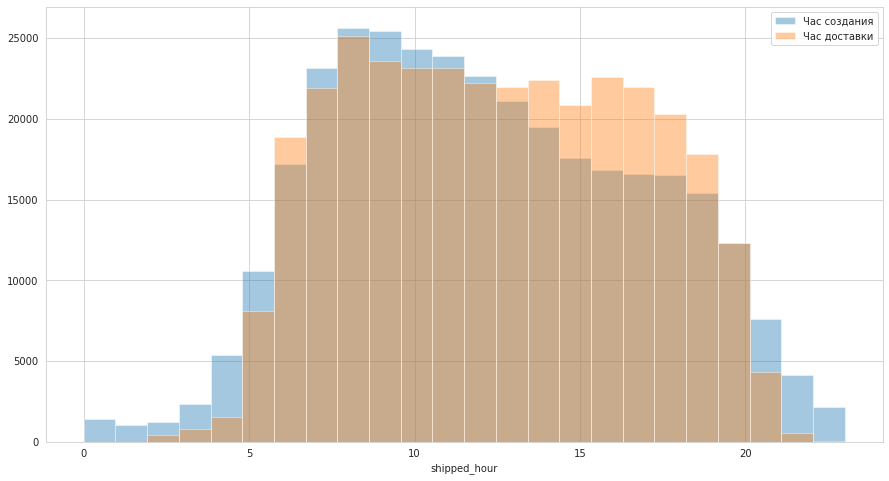

In [ ]:
sns.distplot(analyse_orders_df.created_hour, bins=24, kde=False, label='Час создания')
sns.distplot(analyse_orders_df.shipped_hour, bins=24, kde=False, label='Час доставки')
plt.legend()

Видно, что люди чаще делают заказ в районе обеда, а вот в доставке нет особого перекоса, кроме явного отсутствия доставки поздней ночью.

теперь мы хотим посмотреть динамику роста заказов по городам. Сделаем это несколькими способами

In [ ]:
# Для начала нужно получить фрейм с приростом заказов по городам, отсортированный по времени
City_orders_dict = {}
city_frames_list = []
# получаем прирост по городам
for city in users_by_city.index:
    curr_city_dates = analyse_orders_df[(analyse_orders_df['city_name'] == city)].created_at.values
    curr_city_cummulative_sum = [x+1 for x in range(0,len(curr_city_dates))]
    City_orders_dict[city] = pd.DataFrame.from_dict({'dates': curr_city_dates, 'orders': curr_city_cummulative_sum})

total_city_orders = list(City_orders_dict.values())[0]
# склеиваем всё в один dataframe
for i, frame in enumerate(list(City_orders_dict.values())[1:]):
    total_city_orders = pd.merge(left=total_city_orders, right = frame, how='outer',
                                 left_on='dates', right_on='dates',
                                 suffixes=['_' + users_by_city.index[i], '_' + users_by_city.index[i+1]])
total_city_orders.iloc[0,2:9] = 0
total_city_orders = total_city_orders.sort_values(by=['dates'])
total_city_orders = total_city_orders.fillna(method='ffill').reset_index(drop=True)
total_city_orders.head()

,dates,orders_Москва,orders_Казань,orders_Самара,orders_Нижний Новгород,orders_Уфа,orders_Омск,orders_Одинцово,orders_Подольск
0,2018-01-05 00:07:04,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2018-01-05 02:04:42,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2018-01-05 02:07:35,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2018-01-05 02:15:15,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2018-01-05 02:48:52,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


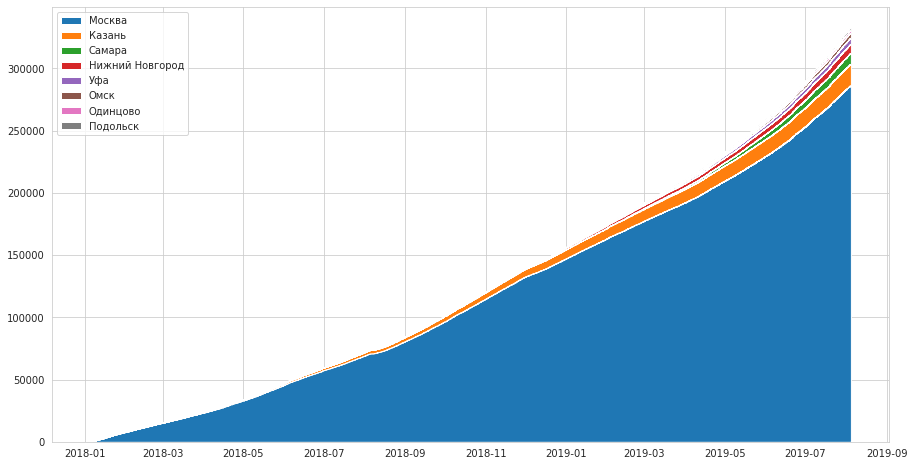

In [ ]:
plt.stackplot(total_city_orders['dates'],total_city_orders.drop(columns='dates').T, labels=users_by_city.index, baseline='zero')
plt.legend(loc='upper left')

Далеко не самый информативный график. Попробуем теперь отобразить это приросты линейно и через barplot

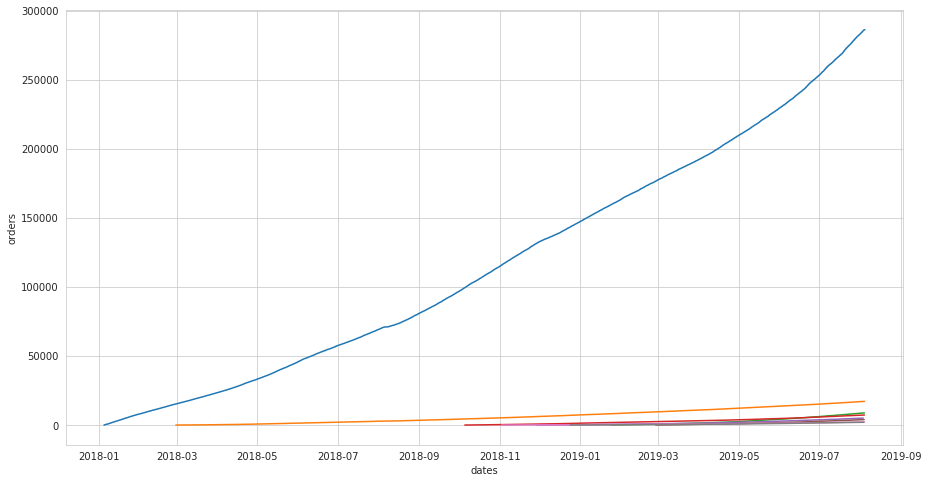

In [ ]:
for city, values in City_orders_dict.items():
    sns.lineplot(x=values['dates'], y=values['orders'])

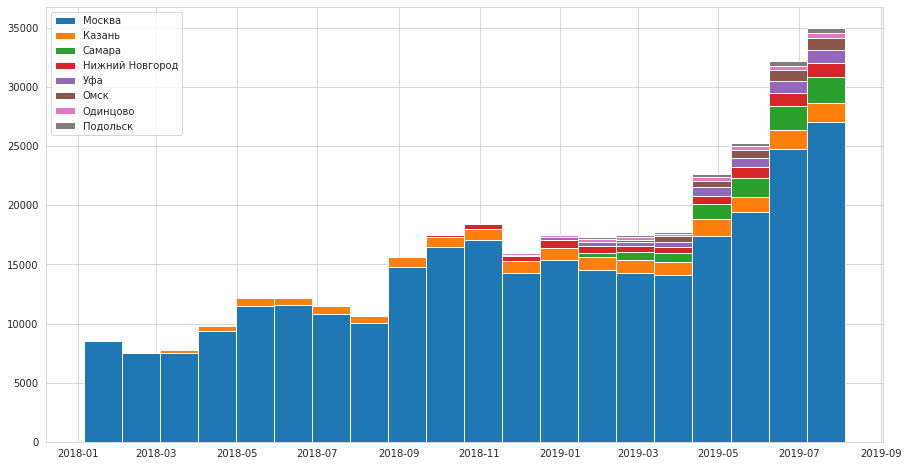

In [ ]:
city_orders_list = []
for city in users_by_city.index:
    curr_city_dates = analyse_orders_df[(analyse_orders_df['city_name'] == city)].created_at.values
    city_orders_list.append(curr_city_dates)
plt.hist(city_orders_list, 20, histtype='bar', stacked=True, label=users_by_city.index)
plt.legend(loc='upper left')

Глобально нам это ничего не дало. Видно, что в целом прирост заказов за полтора года практически линеен (по всем городам)
Видно, что в Казани с 2019 года месячное количество заказов практически не меняется, в о время как в НН есть стабильный рост.
Все это общие наблюдения, которые к сожалению не показывают проблемы и идеи для роста. Хорошо бы посчитать производную прироста, чтобы лучше понять, замедляется он или нет, но к сожалению эта идея пришла только при финальной проверке.

## Среднее время между заказом и доставкой

In [ ]:
for city in users_by_city.index:
    print(f"Для города {city}  среднее время между заказом и доставкой: {analyse_orders_df[(analyse_orders_df['city_name'] == city)].delay.median()}")

Для города Москва  среднее время между заказом и доставкой: 0 days 22:13:27
Для города Казань  среднее время между заказом и доставкой: 0 days 09:05:30
Для города Самара  среднее время между заказом и доставкой: 0 days 21:53:40
Для города Нижний Новгород  среднее время между заказом и доставкой: 0 days 18:35:14
Для города Уфа  среднее время между заказом и доставкой: 0 days 21:56:03
Для города Омск  среднее время между заказом и доставкой: 0 days 19:23:04
Для города Одинцово  среднее время между заказом и доставкой: 0 days 20:43:36
Для города Подольск  среднее время между заказом и доставкой: 0 days 20:24:55.500000


Получается, для всех городов стандарт - примерно сутки между заказом и его поставкой, интересно, чем там отличается Казань?

In [ ]:
# А вот чисто среднее вресмя уже не такое радужное
for city in users_by_city.index:
    print(f"Для города {city}  среднее время между заказом и доставкой: {analyse_orders_df[(analyse_orders_df['city_name'] == city)].delay.mean()}")

Для города Москва  среднее время между заказом и доставкой: 4 days 05:35:43.268289
Для города Казань  среднее время между заказом и доставкой: 3 days 20:08:25.279442
Для города Самара  среднее время между заказом и доставкой: 3 days 23:32:03.961139
Для города Нижний Новгород  среднее время между заказом и доставкой: 3 days 19:09:07.833678
Для города Уфа  среднее время между заказом и доставкой: 4 days 01:56:20.172214
Для города Омск  среднее время между заказом и доставкой: 3 days 10:31:38.117886
Для города Одинцово  среднее время между заказом и доставкой: 3 days 06:00:58.734382
Для города Подольск  среднее время между заказом и доставкой: 4 days 07:52:18.214643


In [ ]:
kazan_df = analyse_orders_df[(analyse_orders_df['city_name'] == "Казань")]
kazan_df = kazan_df.sort_values(by=['delay'])

In [ ]:
kazan_df['delay_in_hours'] = kazan_df['delay']/ np.timedelta64(1, 'h')

собственно, график ниже является подтверждением, что Казани просто повезло, что при огромном разбросе значений, ~10% попадают в < 10 часов.

(0, 48)

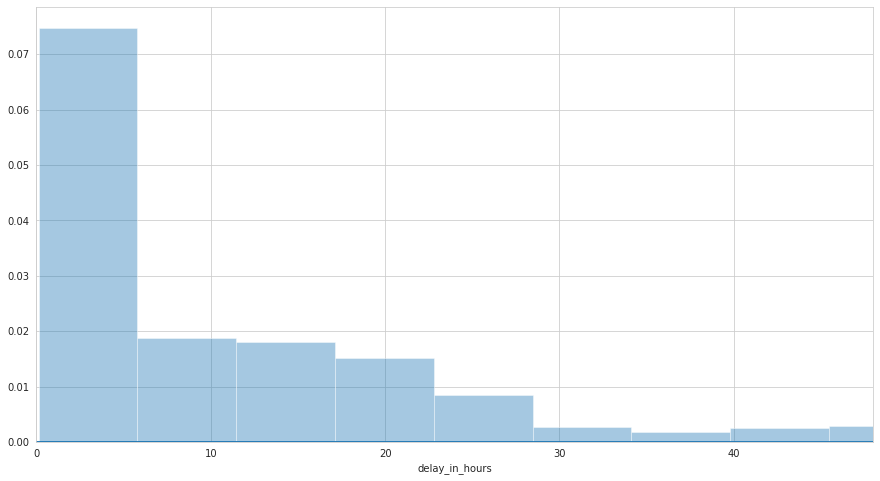

In [ ]:
sns.distplot(kazan_df.delay_in_hours, bins=2000)
plt.xlim([0, 48])

## Зависимость между комплектацией заказа и прочими параметрами

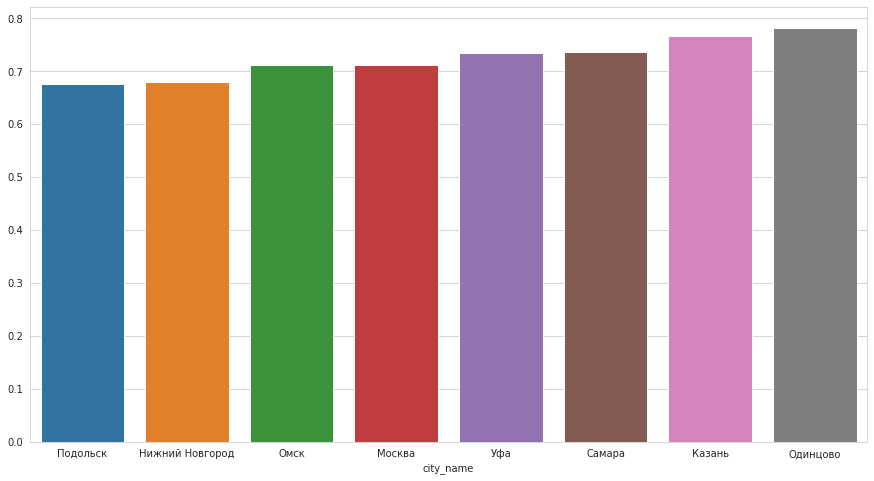

In [ ]:
# смотрим по городам
damaged_percentage = analyse_orders_df.groupby('city_name').mean()['is_damaged'].sort_values()
sns.barplot(x=damaged_percentage.index, y=damaged_percentage.values)

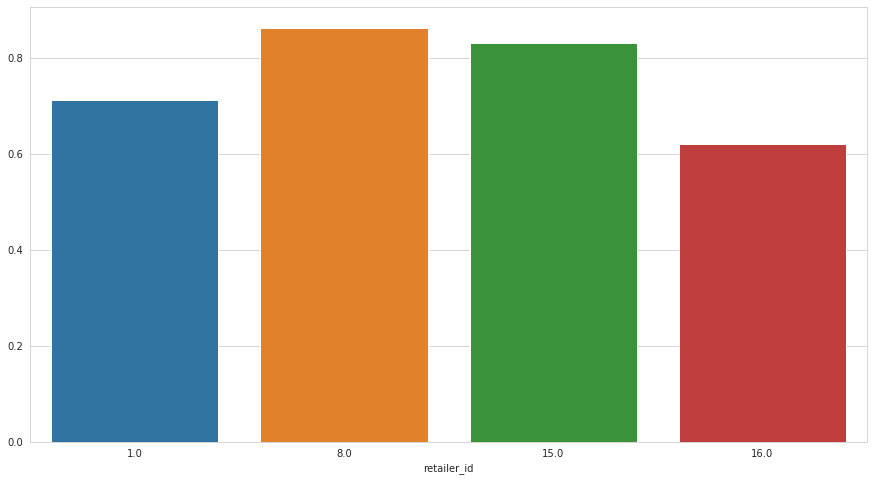

In [ ]:
# смотрим по ритейлерам
damaged_percentage_by_retailer = analyse_orders_df.groupby('retailer_id').mean()['is_damaged'].sort_values()
sns.barplot(x=damaged_percentage_by_retailer.index, y=damaged_percentage_by_retailer.values)

Очень хорошо обстоят дела с комплектацией у ритейлера №16, который, если мне не изменяет память, работает только в одном городе. Интересно, кто это.

In [ ]:
analyse_orders_df[(analyse_orders_df.retailer_id == 16)]['city_name'].unique()

array(['Москва'], dtype=object)

## Проверка указания этажа

теперь хочется проверить теорию, возникшую при выгрузке таблицы  адресами - что чем больше человек сделал/планирует сделать заказов, тем больше вероятность, что у него указан этаж. Сначала я пытался почистить список того, что люди вводят, чтобы вычленить паттерны для прямых указаний на этаж, проходную, консьержа, в общем что-то, что помогало бы курьеру с минимальными усилиями найти нужный адрес.

Но это ад. Помимо этажей, номеров телефонов, нормальных указаний, кто-что-где будет забирать, есть "тестовые записи", неестественные номера этажей, рандомные буквы, но мое любимое - Lorem ipsum dolor...

Надо будет посмотреть, к какому заказу это было сделано.

In [ ]:
floors_list = sorted(list(addresses_df['floor'].unique()))
floors_list

['',
 ' ',
 '       3',
 '   15',
 '  Этаж 5',
 '  этаж 4',
 ' 1',
 ' 1 этаж',
 ' 11',
 ' 12',
 ' 19',
 ' 2',
 ' 2 этаж',
 ' 2 этаж,',
 ' 3 ',
 ' 3 ЭТАЖ',
 ' 5',
 ' 6',
 ' 7',
 ' 7 этаж, ',
 ' 9',
 ' 9  этаж',
 ' 9 этах',
 ' МИНУС- 2 этаж',
 ' Этаж 8',
 ' заберу на первом этаже в лифтовом холле',
 ' со двора',
 ' эт2  под8  код 2112',
 ' этаж 1',
 ' этаж 3',
 ' этаж 4',
 ' этаж 8',
 ' этаж 9',
 '!',
 '"Виноград"',
 '&',
 ')',
 '):):):)',
 '*',
 '+',
 '+79035522224',
 '-',
 '- 1',
 '- 1 этаж',
 '--',
 '---',
 '----',
 '-----',
 '-------',
 '---0',
 '-1',
 '-1 ',
 '-1 (цокольный этаж)',
 '-1 (цокольный)',
 '-1 цокольный',
 '-1 этаж',
 '-2',
 '-2 ',
 '-2 этаж',
 '-3',
 '-4',
 '-5',
 '.',
 '.11',
 '.6',
 '/',
 '0',
 '0 ',
 '0 этаж',
 '00',
 '000',
 '01',
 '02',
 '06',
 '08',
 '1',
 '1 ',
 '1  ',
 '1  детский клуб Тёма вывеска',
 '1  этаж',
 "1 'nf;",
 '1 ( ул. Центральная ) ',
 '1 (вход с улицы)',
 '1 (заберем у турникета)',
 '1 (здание канатной дороги)',
 '1 (на пролет мимом лифта)',
 '1 

In [ ]:
def is_floor(floor):
    try:
        if 'этаж' in floor.lower():
            return 1
        elif int(floor) < 97:
            return 1
        else:
            return 0
    except ValueError:
        return 0
    except AttributeError:
        return 0

In [ ]:
check_sum_test['is_floor'] = check_sum_test.apply(lambda row: is_floor(row['floor']), axis=1)

In [ ]:
# mean в нашем случае будет % указавших этаж
floor_by_occurrence = check_sum_test.drop_duplicates(['user_id'], keep='last')
# floor_by_occurrence.info()
floor_by_occurrence = floor_by_occurrence.groupby('occurence_num').mean()['is_floor']
floor_by_occurrence.head()

occurence_num
1    0.871820
2    0.903881
3    0.913514
4    0.917892
5    0.916955
Name: is_floor, dtype: float64

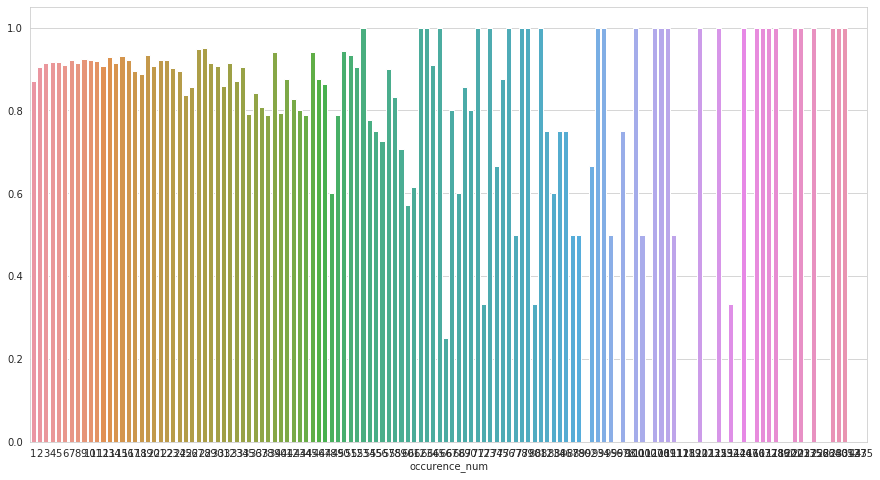

In [ ]:
sns.barplot(x=floor_by_occurrence.index, y=floor_by_occurrence.values)
# sns.distplot(floor_by_occurrence.values)

не самый красивый график (как-никак у нас есть юзеры с 1-475 заказами.), но в том приближении проверки этажей, которое есть сейчас, он разбивает теорию о связи между четким указанием этажа и количеством заказов.
Но зато возникает подозрение, что floor в таблице собирает вообще все указания адреса, кроме координат (т.е. этаж, подъезд, домофон, комментарии, вообще все в одно поле).


In [ ]:
# какая-то одинокая избушка в районе Лосиного острова, доставка за 17 минут. Такое ощущение, что чей-то тест
analyse_orders_df[(analyse_orders_df['floor'].str.contains(r'Lorem', na=True))]

,id_x,user_id,total_cost,cost,item_total,promo_total,total_weight,total_quantity,state,shipped_at,created_at,ship_address_id,store_id,delivery_window_id,is_damaged,city,retailer_id,lat,lon,id_y,elevator,floor,total,discount,delay,created_hour,shipped_hour,day,city_name,month,year
135894,4009960,123143,299.0,299.0,4542,0.0,13175,19,shipped,2018-11-22 14:37:30,2018-11-22 14:20:25,1207919,18,309315.0,1,1.0,1.0,55.873506,37.724939,1207919.0,passenger,"Lorem ipsum dolor sit amet, consectetur adipis...",4841.0,0.0,00:17:05,14,14,326,Москва,11,2018


## Дубликаты заказов

В профиле мы видели заказы с одинаковыми id/ посмотрим на них поближе. 
На первый взгляд в каждой паре дубликатов второй заказ сделан позже. Оставим вопрос, почему первый в таком случае не становится cancelled, и почему у них одинаковые id, но судя по всему это просто тем или иным способом модифицированные заказы (добавлен товар, измененм магазин или адрес доставки, и тд.)

In [ ]:
analyse_orders_df[(analyse_orders_df.duplicated(subset=['id'], keep=False))].sort_values(by=['id'])

,id,user_id,total_cost,cost,item_total,promo_total,total_weight,total_quantity,state,shipped_at,created_at,ship_address_id,store_id,delivery_window_id,is_damaged
258839,142752,746,199.0,199.0,5905,0.0,19600,26,shipped,2019-05-30 16:54:49,2019-05-29 19:12:43,2046944,2,527380.0,0
258846,142752,746,299.0,299.0,2971,0.0,19420,27,shipped,2019-05-30 14:29:32,2019-05-29 19:27:12,2046944,70,526494.0,1
49532,191390,7748,0.0,0.0,3271,-500.0,3580,8,shipped,2018-06-04 16:33:46,2018-06-02 14:16:52,747603,14,165308.0,1
49520,191390,7748,0.0,0.0,1724,0.0,11800,13,shipped,2018-06-03 15:17:28,2018-06-02 14:03:12,747603,70,165160.0,1
29751,3019123,105725,0.0,0.0,4624,0.0,32903,51,shipped,2018-04-18 09:42:57,2018-04-17 12:50:22,632902,2,134919.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
330534,5450607,41075,158.0,249.0,2005,0.0,8490,17,shipped,2019-08-04 06:34:23,2019-08-01 10:10:46,2605452,14,637226.0,1
331044,5465240,661610,0.0,249.0,3742,0.0,10325,16,shipped,2019-08-02 09:05:51,2019-08-01 17:03:27,2620276,14,633625.0,0
330984,5465240,661610,0.0,0.0,1297,0.0,2700,6,shipped,2019-08-02 08:44:49,2019-08-01 16:23:05,2620276,70,634212.0,1
332900,5487474,670981,0.0,0.0,970,0.0,6835,12,shipped,2019-08-03 13:15:53,2019-08-03 07:00:01,2642823,92,636339.0,0


## Общая цена заказа (item_total)

Теперь посмотрим на аномально большие чеки (>100к, кто столько заказывает, подумал я, пока не увидел у вас в инстраграмме чек на 2 ляма)


In [ ]:
high_cost_orders = analyse_orders_df[(analyse_orders_df['item_total'] > 100000)]

In [ ]:
high_cost_orders.describe()

,id,user_id,total_cost,cost,item_total,promo_total,total_weight,total_quantity,ship_address_id,store_id,delivery_window_id,is_damaged
count,1.230000e+02,123.000000,123.000000,123.000000,123.000000,123.000000,1.230000e+02,123.000000,1.230000e+02,123.000000,123.000000,123.000000
mean,4.386599e+06,208762.878049,471.691057,772.560976,151762.146341,-1142.909268,6.492206e+05,1051.065041,1.572098e+06,19.934959,405233.243902,0.634146
std,6.686707e+05,183242.828713,960.752839,1157.777075,73599.985168,5397.336701,8.035848e+05,913.950484,6.387365e+05,27.099313,164277.053390,0.483639
min,3.299526e+06,9892.000000,0.000000,0.000000,100112.000000,-39899.300000,0.000000e+00,1.000000,5.626140e+05,1.000000,115186.000000,0.000000
25%,3.816860e+06,34400.000000,0.000000,0.000000,108462.000000,0.000000,1.329950e+05,387.500000,1.024321e+06,2.000000,265427.000000,0.000000
50%,4.187329e+06,165626.000000,0.000000,464.000000,119498.000000,0.000000,4.345420e+05,954.000000,1.387675e+06,10.000000,382635.000000,1.000000
75%,5.181686e+06,206223.500000,599.000000,775.000000,164524.500000,0.000000,7.464010e+05,1288.000000,2.320210e+06,21.000000,587473.500000,1.000000
max,5.487874e+06,671174.000000,5000.000000,6484.000000,480746.000000,0.000000,3.847250e+06,4322.000000,2.643227e+06,95.000000,635440.000000,1.000000


Идем по колонкам - сначала занятные примеры с общим весом 0 грамм и количеством товара 1 шт.

In [ ]:
# по 1 штуке
one_item = high_cost_orders[(high_cost_orders['total_quantity'] == 1)].reset_index(drop=True)
one_item

,id,user_id,total_cost,cost,item_total,promo_total,total_weight,total_quantity,state,shipped_at,created_at,ship_address_id,store_id,delivery_window_id,is_damaged
0,3730741,148170,299.0,299.0,149150,0.00,5500,1,shipped,2018-09-12 16:50:49,2018-09-12 14:15:37,943715,2,240733.0,0
1,4049731,196821,0.0,1194.0,113704,-9904.02,1000,1,shipped,2018-12-02 19:00:00,2018-12-01 13:59:52,1246571,2,319856.0,1
2,4051986,197223,0.0,1791.0,163622,-15768.24,3350,1,shipped,2018-12-02 15:12:00,2018-12-02 10:30:42,1248790,2,319867.0,0
3,4053661,197558,0.0,1791.0,163135,-16289.50,3350,1,shipped,2018-12-03 10:03:00,2018-12-02 20:21:22,1250491,2,320938.0,0
4,4053675,197558,2786.0,2786.0,256247,-39899.30,3350,1,shipped,2018-12-06 11:54:18,2018-12-03 09:36:36,1250505,2,324281.0,0
5,4049744,196821,1791.0,1791.0,170945,-25463.37,3350,1,shipped,2018-12-08 14:35:00,2018-12-06 16:47:21,1246585,2,326650.0,0
6,5364007,614213,943.0,994.0,202774,0.00,1000,1,shipped,2019-07-30 08:19:53,2019-07-25 08:54:06,2518714,12,627724.0,0
7,5487874,671174,0.0,206.0,109172,0.00,0,1,shipped,2019-08-03 14:44:27,2019-08-03 07:25:35,2643227,14,635440.0,1


странными кажутся строчки 3-4. Один и тот же юзер заказал, судя по весу плюс-минус одинаковые товары, причем второй был заказан за полчаса до доставки первого. Причем и в первом, и во втором случае была ощутимая скидка. Магазин один и тот же, а вот адреса доставки разные.

In [ ]:
analyse_orders_df[(analyse_orders_df['user_id'] == 197558)]

,id,user_id,total_cost,cost,item_total,promo_total,total_weight,total_quantity,state,shipped_at,created_at,ship_address_id,store_id,delivery_window_id,is_damaged
142387,4053661,197558,0.0,1791.0,163135,-16289.5,3350,1,shipped,2018-12-03 10:03:00,2018-12-02 20:21:22,1250491,2,320938.0,0
142587,4053675,197558,2786.0,2786.0,256247,-39899.3,3350,1,shipped,2018-12-06 11:54:18,2018-12-03 09:36:36,1250505,2,324281.0,0


Разные только id, сами адреса одинаковые. Ведут они на улицу Кирпичные Выемки, судя по всему это промзона.
Вообще, такое ощущение, что это некое юрлицо заказывало какое-то оборудование, и либо изменило заказ, либо реально заказывало его два раза. (по этому адресу обычный пользователь может выбрать только доставку из Метро, причем там ничего такого дорогого нет). Вообще, почему товар при второй покупке стал на 100к дороже ,нет идей.

In [ ]:
addresses_df[(addresses_df['id'].isin(analyse_orders_df[(analyse_orders_df['user_id'] == 197558)]['ship_address_id']))]

,lat,lon,id,elevator,floor
281863,55.585747,37.606406,1250491,None,-
281867,55.585747,37.606406,1250505,None,-


Есть еще занятный заказ №7 - там товар не найден, возможно поэтому его вес и равен нулю. Но при этом он отправлен, и даже пользовались скидкой на доставку.

In [ ]:
# приверим эту теорию
orders_df[(orders_df.total_quantity == 1) & (orders_df.is_damaged == 1)]['total_weight'].mean()
# нет 2,6 кг намекают, что не в этом дело

2636.7627906976745

In [ ]:
# переходим к невесомым и дорогим
no_weight = high_cost_orders[(high_cost_orders['total_weight'] == 0)].reset_index(drop=True)
no_weight

,id,user_id,total_cost,cost,item_total,promo_total,total_weight,total_quantity,state,shipped_at,created_at,ship_address_id,store_id,delivery_window_id,is_damaged
0,5487874,671174,0.0,206.0,109172,0.0,0,1,shipped,2019-08-03 14:44:27,2019-08-03 07:25:35,2643227,14,635440.0,1


здесь сложно судить - товар не был найден, мб и не был отправлен на самом деле, может быть поэтому и ноль.

In [ ]:
# теперь переходим к аномально дешевым заказам - примем, что это те чеки, где доставка 
# (согласно расценкам на сайте) будет превышать сам чек
low_cost_orders = analyse_orders_df[(analyse_orders_df['item_total'] < 98)]

Здесь нас будут интересовать заказы, при низкой цене обладающие большим весом (глянем еще количество, но есть куча историй про заказы одного шурупа отдельными чеками, поэтому вряд ли что-то нам это даст)

In [ ]:
low_cost_orders.describe()

,id,user_id,total_cost,cost,item_total,promo_total,total_weight,total_quantity,ship_address_id,store_id,delivery_window_id,is_damaged
count,6.080000e+02,608.000000,608.000000,608.000000,608.000000,608.000000,608.000000,608.000000,6.080000e+02,608.000000,608.000000,608.000000
mean,4.064728e+06,205114.398026,86.684211,196.488487,49.166118,-45.317829,10830.541118,12.763158,1.279790e+06,29.796053,331040.606908,0.577303
std,6.286209e+05,135804.263187,122.873995,142.817887,28.450837,132.080470,16706.810750,10.348451,5.773540e+05,34.122435,158034.816485,0.494395
min,9.680380e+05,5836.000000,0.000000,0.000000,0.000000,-1000.000000,0.000000,0.000000,1.471770e+05,1.000000,76343.000000,0.000000
25%,3.542567e+06,106560.750000,0.000000,0.000000,26.000000,0.000000,2645.000000,5.000000,7.603075e+05,8.000000,179963.250000,0.000000
50%,4.050535e+06,180214.000000,0.000000,249.000000,49.000000,0.000000,5778.500000,11.000000,1.248937e+06,12.000000,331767.000000,1.000000
75%,4.440740e+06,256427.750000,149.000000,299.000000,74.000000,0.000000,11757.500000,17.000000,1.649102e+06,62.000000,455440.000000,1.000000
max,5.506156e+06,679270.000000,814.000000,899.000000,97.000000,0.000000,135000.000000,72.000000,2.662411e+06,118.000000,638015.000000,1.000000


Если вернуться к общей картине

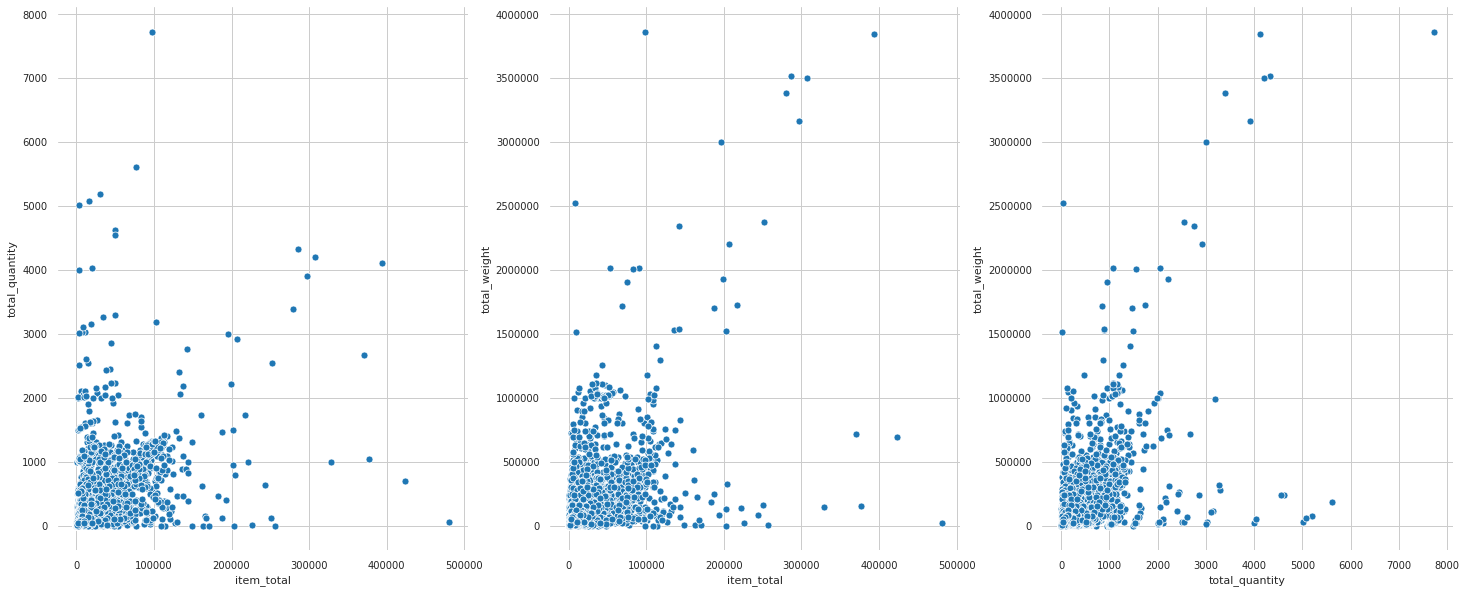

In [ ]:
fig, ax = plt.subplots(1,3)
fig.set_size_inches(25, 10)
sns.scatterplot(orders_df['item_total'],orders_df['total_quantity'], ax=ax[0])
sns.scatterplot(orders_df['item_total'],orders_df['total_weight'], ax=ax[1])
sns.scatterplot(orders_df['total_quantity'],orders_df['total_weight'], ax=ax[2])

То все кажется логичным - в среднем цена и вес заказа напрямую связаны с количеством заказанных товаров. Также заказы делятся на три категории - красные - дорогие товары, где при малом количестве все равно высокая цена, серые - что-то простое (коробки с печеньками, спички, салфетки), что даже при большом количестве не набирается на большую стоимость. И зеленые - середнячки, товары, которые нельзя отнести ни к предметам роскоши, ни первой необходимости.

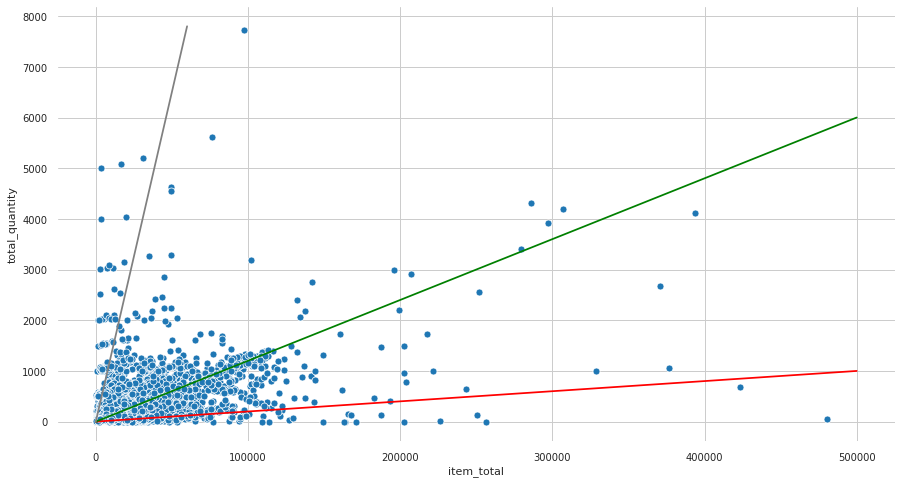

In [ ]:
sns.scatterplot(orders_df['item_total'],orders_df['total_quantity'])
x = np.linspace(0, 500000, 100)
x_estr = np.linspace(0, 60000, 100)
sns.lineplot(x, 0.002 * x, color='red');
sns.lineplot(x, 0.012 * x, color='green');
sns.lineplot(x_estr, 0.13 * x_estr, color='gray');

Если в целом, то как мне кажется, любая аномалия из этой базы имеет разумное объяснение, и является либо разовой странной покупкой, либо шумом/багом приложения, а не какой-то попыткой фрода.